## CMC7 Tesseract MICR: OCR

Dataset Source: https://github.com/DoubangoTelecom/tesseractMICR/tree/master/datasets/cmc7

#### Install Necessary & Missing Libraries

In [1]:
%pip install transformers torch torchvision
%pip install evaluate datasets jiwer
%pip install accelerate -U
%pip install scikit-learn -U

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.4/7.4 MB 18.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 268.8/268.8 kB 20.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.8/7.8 MB 35.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 36.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 81.4/81.4 kB 1.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 486.2/486.2 kB 21.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 115.3/115.3 kB 17.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 212.5/212.5 kB 27.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.8/134.8 kB 19.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 110.5/110.5 kB 15.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.2/2.2 MB 63.5 MB/s eta 0:00:00
INFO: pip is looking at multiple versions of multiprocess to determine which version is compatible with other requirem

#### Import Necessary Libraries

In [2]:
import os, sys, itertools, glob
os.environ['TOKENIZERS_PARALLELISM']='false'

import pandas as pd
import matplotlib.pyplot as plt

from PIL import Image

import torch
from torch.utils.data import Dataset

import datasets
from datasets import load_dataset

import sklearn
from sklearn.model_selection import train_test_split

import transformers
from transformers import Seq2SeqTrainingArguments, Seq2SeqTrainer
from transformers import VisionEncoderDecoderModel, TrOCRProcessor, default_data_collator

import evaluate

!git lfs install

Git LFS initialized.


#### Login For Access to HuggingFace

In [3]:
!huggingface-cli login


    _|    _|  _|    _|    _|_|_|    _|_|_|  _|_|_|  _|      _|    _|_|_|      _|_|_|_|    _|_|      _|_|_|  _|_|_|_|
    _|    _|  _|    _|  _|        _|          _|    _|_|    _|  _|            _|        _|    _|  _|        _|
    _|_|_|_|  _|    _|  _|  _|_|  _|  _|_|    _|    _|  _|  _|  _|  _|_|      _|_|_|    _|_|_|_|  _|        _|_|_|
    _|    _|  _|    _|  _|    _|  _|    _|    _|    _|    _|_|  _|    _|      _|        _|    _|  _|        _|
    _|    _|    _|_|      _|_|_|    _|_|_|  _|_|_|  _|      _|    _|_|_|      _|        _|    _|    _|_|_|  _|_|_|_|
    
    To login, `huggingface_hub` requires a token generated from https://huggingface.co/settings/tokens .
Token: 
Add token as git credential? (Y/n) n
Token is valid (permission: write).
Your token has been saved to /root/.cache/huggingface/token
Login successful


#### Mount Google Drive to Notebook

In [4]:
from google.colab import drive

drive.mount('/content/drive')

Mounted at /content/drive


#### Display Versions of Relevant Software & Libraries

In [5]:
print("Python:".rjust(15), sys.version[0:6])
print("Pandas:".rjust(15), pd.__version__)
print("Datasets:".rjust(15), datasets.__version__)
print("Torch:".rjust(15), torch.__version__)
print("Transformers:".rjust(15), transformers.__version__)
print("Evaluate:".rjust(15), evaluate.__version__)
print("Sklearn:".rjust(15), sklearn.__version__)

        Python: 3.10.6
        Pandas: 1.5.3
      Datasets: 2.13.1
         Torch: 2.0.1+cu118
  Transformers: 4.31.0
      Evaluate: 0.4.0
       Sklearn: 1.3.0


#### Ingest & Preprocess Training Dataset

In [13]:
parent_dir = "/content/drive/MyDrive/projects/cmc7/cmc7/"
tif_files = glob.glob(parent_dir + "*.tif")
txt_files = glob.glob(parent_dir + "*.txt")

# Create dataframe of each list
tif_df = pd.DataFrame(tif_files, columns=['file_name'])
txt_df = pd.DataFrame(txt_files, columns=['text_file'])

# Then create new column with the integer value at the value
tif_df['sample_id'] = tif_df['file_name'].apply(lambda x: x.split(".")[0].split("_")[-1])
txt_df['sample_id'] = txt_df['text_file'].apply(lambda x: x.split(".")[0].split("_")[-1])

# Make all paths relative (to this directory)
tif_df['file_name'] = tif_df['file_name'].apply(lambda x: x.split("/cmc7/")[-1])

# set index for concatenation
tif_df = tif_df.set_index(keys='sample_id')
txt_df = txt_df.set_index(keys='sample_id')

# concatenate the two dataframes based on that column
df = pd.concat([tif_df, txt_df], axis=1, join='inner')

df = df.dropna()

df = df.drop_duplicates()

df = df.reset_index(drop=True)

df

,file_name,text_file
0,cmc7/tesseract_cmc7_font_generator_00001868.tif,/content/drive/MyDrive/projects/cmc7/cmc7/tess...
1,cmc7/tesseract_cmc7_font_generator_00000088.tif,/content/drive/MyDrive/projects/cmc7/cmc7/tess...
2,cmc7/tesseract_cmc7_font_generator_00000608.tif,/content/drive/MyDrive/projects/cmc7/cmc7/tess...
3,cmc7/tesseract_cmc7_font_generator_00001197.tif,/content/drive/MyDrive/projects/cmc7/cmc7/tess...
4,cmc7/tesseract_cmc7_font_generator_00001567.tif,/content/drive/MyDrive/projects/cmc7/cmc7/tess...
...,...,...
3001,cmc7/tesseract_cmc7_font_generator_00002548.tif,/content/drive/MyDrive/projects/cmc7/cmc7/tess...
3002,cmc7/tesseract_cmc7_font_generator_00001128.tif,/content/drive/MyDrive/projects/cmc7/cmc7/tess...
3003,cmc7/tesseract_cmc7_font_generator_00001469.tif,/content/drive/MyDrive/projects/cmc7/cmc7/tess...
3004,cmc7/tesseract_cmc7_font_generator_00001123.tif,/content/drive/MyDrive/projects/cmc7/cmc7/tess...


#### Convert Text File Names to Text Contained In Files

In [14]:
def replace_file_name_with_contents(file_path):
    with open(file_path, 'r') as file:
        return file.read()

df['text'] = df['text_file'].apply(replace_file_name_with_contents)

df = df.drop(columns=['text_file'])

df

,file_name,text
0,cmc7/tesseract_cmc7_font_generator_00001868.tif,H5398391 H301796346367I 496090255170F 05199G
1,cmc7/tesseract_cmc7_font_generator_00000088.tif,H8110582 H882817108149I 202976112724F
2,cmc7/tesseract_cmc7_font_generator_00000608.tif,H7858877 H685315008146I
3,cmc7/tesseract_cmc7_font_generator_00001197.tif,H9986574H 441349536028I 049986175477F
4,cmc7/tesseract_cmc7_font_generator_00001567.tif,H9693054 H926034426112I 517843777942F 37057G
...,...,...
3001,cmc7/tesseract_cmc7_font_generator_00002548.tif,J39H9388541J322226245828J
3002,cmc7/tesseract_cmc7_font_generator_00001128.tif,H6926013H 770160775918I 441072377704F
3003,cmc7/tesseract_cmc7_font_generator_00001469.tif,H2840031H 010005224772I 337828919144F
3004,cmc7/tesseract_cmc7_font_generator_00001123.tif,H4579999H 976212805167I 066140678390F


#### Clean Up Text/Labels

In [15]:
# Replace all letters with spaces
df['text'] = df['text'].str.replace('[a-zA-Z]', ' ', regex=True)

# Then replace all instances of multiple
# consecutive spaces with single space
df['text'] = df['text'].apply(lambda x: ' '.join(x.split()))

# Remove all leading & trailing whitespace
df['text'] = df['text'].apply(lambda x: x.strip())

df.head()

,file_name,text
0,cmc7/tesseract_cmc7_font_generator_00001868.tif,5398391 301796346367 496090255170 05199
1,cmc7/tesseract_cmc7_font_generator_00000088.tif,8110582 882817108149 202976112724
2,cmc7/tesseract_cmc7_font_generator_00000608.tif,7858877 685315008146
3,cmc7/tesseract_cmc7_font_generator_00001197.tif,9986574 441349536028 049986175477
4,cmc7/tesseract_cmc7_font_generator_00001567.tif,9693054 926034426112 517843777942 37057


#### Visualize: Histogram of Text Lengths

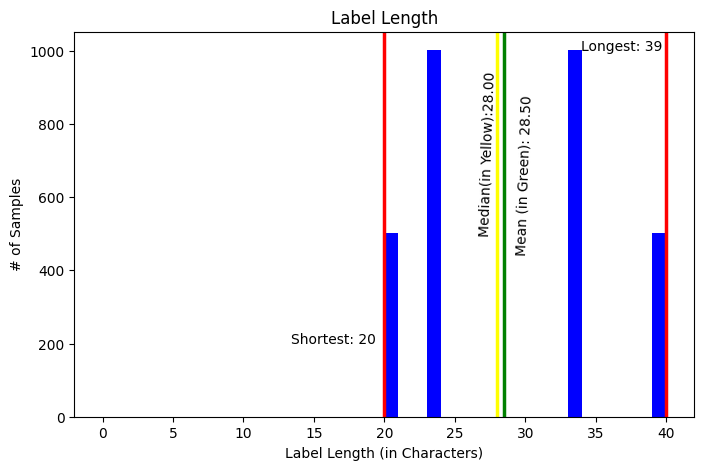

The string values range from 20 to 39 characters.


In [16]:
df['label_len'] = df['text'].str.len()

MIN_LENGTH_VALUE = min(df['label_len'])
MAX_LENGTH_VALUE = max(df['label_len'])
LENGTH_VALUE_MEAN = df['label_len'].mean()
LENGTH_VALUE_MEDIAN = df['label_len'].median()

graph_y_max = 1000

df.hist("label_len",
        grid=False,
        color="Blue",
        figsize=(8,5),
        bins=MAX_LENGTH_VALUE + 1,
        range=(0, MAX_LENGTH_VALUE + 1)
        )

plt.suptitle('')
plt.xlabel('Label Length (in Characters)')
plt.ylabel('# of Samples')
plt.title('Label Length')

# Display & label vertical line @ minimum value
plt.axvline(MIN_LENGTH_VALUE, color='red', linestyle='solid', linewidth=2.5)
plt.text(MIN_LENGTH_VALUE * 0.67, graph_y_max * 0.20, 'Shortest: {:.0f}'.format(MIN_LENGTH_VALUE))

# Display & label vertical line @ maximum value
plt.axvline(MAX_LENGTH_VALUE + 1, color='red', linestyle='solid', linewidth=2.5)
plt.text(MAX_LENGTH_VALUE * 0.87, graph_y_max * 1.00, 'Longest: {:.0f}'.format(MAX_LENGTH_VALUE))

# Display & label vertical line @ median value
plt.axvline(LENGTH_VALUE_MEDIAN,
            color='yellow',
            linestyle='solid',
            linewidth=2.5)

plt.text(LENGTH_VALUE_MEDIAN * 0.95,
         graph_y_max * 0.50,
         'Median(in Yellow):{:.2f}'.format(LENGTH_VALUE_MEDIAN),
         rotation=88)

# Display & label vertical line @ mean value
plt.axvline(LENGTH_VALUE_MEAN,
            color='green',
            linestyle='solid',
            linewidth=2.5)

plt.text(LENGTH_VALUE_MEAN * 1.025,
         graph_y_max * 0.45,
         'Mean (in Green): {:.2f}'.format(LENGTH_VALUE_MEAN),
         rotation=88)

plt.show()

print(f"The string values range from {MIN_LENGTH_VALUE} to {MAX_LENGTH_VALUE} characters.")

df = df.drop(columns=['label_len'])

#### Split Dataset into Training & Testing Datasets

In [17]:
train_df, test_df = train_test_split(df,
                                     test_size=0.17,
                                     random_state=42)

train_df = train_df.reset_index(drop=True)
test_df = test_df.reset_index(drop=True)

print(f"Training Dataset Shape: {train_df.shape}")
print(f"Testing Dataset Shape: {test_df.shape}")

Training Dataset Shape: (2494, 2)
Testing Dataset Shape: (512, 2)


#### Create Dataset Class

In [18]:
class CMC7_Tesseract_MICR_OCR_Dataset(Dataset):

    def __init__(self,
                 root_dir,
                 df,
                 processor,
                 max_target_length=40):

        self.root_dir = root_dir
        self.df = df
        self.processor = processor
        self.max_target_length = max_target_length

    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
        # get file name + text
        file_name = self.df['file_name'][idx]
        text = self.df['text'][idx]
        # prepare image (i.e. resize + normalize)
        image = Image.open(self.root_dir + file_name).convert("RGB")
        pixel_values = self.processor(image, return_tensors="pt").pixel_values
        # add labels (input_ids) by encoding the text
        labels = self.processor.tokenizer(text,
                                          padding="max_length",
                                          max_length=self.max_target_length
                                          ).input_ids
        # important: make sure that PAD tokens are ignored by loss function
        labels = [label if label != self.processor.tokenizer.pad_token_id
                  else -100 for label in labels]

        encoding = {"pixel_values" : pixel_values.squeeze(), "labels" : torch.tensor(labels)}
        return encoding

##### Basic Values/Constants

In [20]:
MODEL_CKPT = "microsoft/trocr-large-printed"
MODEL_NAME =  MODEL_CKPT.split("/")[-1] + "-cmc7_tesseract_MICR_ocr"

NUM_OF_EPOCHS = 5
BATCH_SIZE = 8

REPORTS_TO = "tensorboard"
STRATEGY = "epoch"

DEVICE = torch.device("cuda")
print(DEVICE)

cuda


##### Instantiate Processor, Create Training, & Testing Dataset Instances

In [28]:
parent_dir = "/content/drive/MyDrive/projects/cmc7/"

image_processor = TrOCRProcessor.from_pretrained(MODEL_CKPT)

train_ds = CMC7_Tesseract_MICR_OCR_Dataset(root_dir=parent_dir,
                                           df=train_df,
                                           processor=image_processor)

test_ds = CMC7_Tesseract_MICR_OCR_Dataset(root_dir=parent_dir,
                                          df=test_df,
                                          processor=image_processor)

Could not find image processor class in the image processor config or the model config. Loading based on pattern matching with the model's feature extractor configuration.


##### Print Length of Training & Testing Datasets

In [29]:
print(f"The training dataset has {len(train_ds)} samples in it.")
print(f"The testing dataset has {len(test_ds)} samples in it.")

The training dataset has 2494 samples in it.
The testing dataset has 512 samples in it.


##### Example of Input Data Shapes

In [30]:
encoding = train_ds[5]

for k,v in encoding.items():
    print(k.rjust(12, " "), ":", v.shape)

pixel_values : torch.Size([3, 384, 384])
      labels : torch.Size([40])


##### Show Example

/content/drive/MyDrive/projects/cmc7/cmc7/tesseract_cmc7_font_generator_00001537.tif


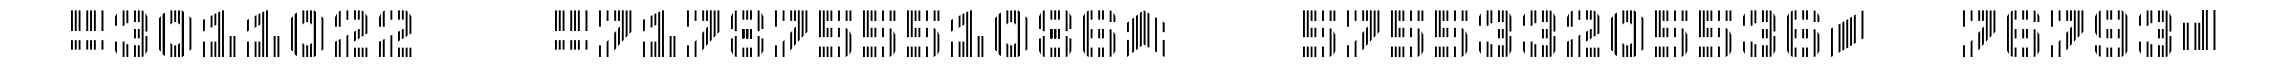

In [31]:
print(train_ds.root_dir + train_df['file_name'][0])

image = Image.open(train_ds.root_dir + train_df['file_name'][0]).convert("RGB")

image

##### Show Label for Above Example

In [32]:
labels = encoding['labels']
labels[labels == -100] = image_processor.tokenizer.pad_token_id
label_str = image_processor.decode(labels, skip_special_tokens=True)
print(label_str)

5541587 048218278578 333619595084 88009


#### Instantiate Model

In [33]:
model = (
    VisionEncoderDecoderModel.from_pretrained(MODEL_CKPT)
    ).to(DEVICE)

Some weights of VisionEncoderDecoderModel were not initialized from the model checkpoint at microsoft/trocr-large-printed and are newly initialized: ['encoder.pooler.dense.bias', 'encoder.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


##### Model Configuration Modifications

In [34]:
model.config.decoder_start_token_id = image_processor.tokenizer.cls_token_id
model.config.pad_token_id = image_processor.tokenizer.pad_token_id

model.config.vocab_size = model.config.decoder.vocab_size

model.config.eos_token_id = image_processor.tokenizer.sep_token_id
model.config.max_length = MAX_LENGTH_VALUE
model.config.early_stopping = True
model.config.no_repeat_ngram_size = 3
model.config.length_penalty = -1
model.config.num_beams = 8

##### Define Metrics Evaluation

In [35]:
cer_metric = evaluate.load("cer")

def compute_metrics(pred):
    label_ids = pred.label_ids
    pred_ids = pred.predictions

    pred_str = image_processor.batch_decode(pred_ids, skip_special_tokens=True)
    label_ids[label_ids == -100] = image_processor.tokenizer.pad_token_id
    label_str = image_processor.batch_decode(label_ids, skip_special_tokens=True)

    cer = cer_metric.compute(predictions=pred_str, references=label_str)

    return {"cer" : cer}

#### Define Training Arguments

In [37]:
args = Seq2SeqTrainingArguments(
    output_dir = MODEL_NAME,
    num_train_epochs=NUM_OF_EPOCHS,
    predict_with_generate=True,
    evaluation_strategy="no",
    save_strategy=STRATEGY,
    logging_strategy="steps",
    logging_steps=31,
    logging_first_step=True,
    report_to=REPORTS_TO,
    auto_find_batch_size=True,
    hub_private_repo=True,
    push_to_hub=True
)

##### Define Trainer

In [38]:
trainer = Seq2SeqTrainer(
    model=model,
    tokenizer=image_processor.feature_extractor,
    args=args,
    compute_metrics=compute_metrics,
    train_dataset=train_ds,
    eval_dataset=test_ds,
    data_collator=default_data_collator
)

/usr/local/lib/python3.10/dist-packages/transformers/models/trocr/processing_trocr.py:135: FutureWarning: `feature_extractor` is deprecated and will be removed in v5. Use `image_processor` instead.
  warnings.warn(
Cloning https://huggingface.co/DunnBC22/trocr-large-printed-cmc7_tesseract_MICR_ocr into local empty directory.


##### Fit/Train Model

In [39]:
train_results = trainer.train()

/usr/local/lib/python3.10/dist-packages/transformers/optimization.py:411: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


Step,Training Loss


Step,Training Loss
1,9.160900
31,6.118100
62,5.501200
93,4.629400
124,4.384200
155,4.113000
186,4.490700
217,4.059000
248,3.947500
279,3.617200


##### Save Model & Training Metrics

In [40]:
trainer.save_model()
trainer.save_state()

Several commits (2) will be pushed upstream.
The progress bars may be unreliable.


Upload file runs/Jul23_18-53-49_d4bbd6913ce1/events.out.tfevents.1690138435.d4bbd6913ce1.427.0:   0%|         …

To https://huggingface.co/DunnBC22/trocr-large-printed-cmc7_tesseract_MICR_ocr
   02514a2..b6dc77e  main -> main

   02514a2..b6dc77e  main -> main

To https://huggingface.co/DunnBC22/trocr-large-printed-cmc7_tesseract_MICR_ocr
   b6dc77e..5815323  main -> main

   b6dc77e..5815323  main -> main



#### Evaluate Model

In [41]:
metrics = trainer.evaluate()

/usr/local/lib/python3.10/dist-packages/transformers/generation/utils.py:1270: UserWarning: You have modified the pretrained model configuration to control generation. This is a deprecated strategy to control generation and will be removed soon, in a future version. Please use a generation configuration file (see https://huggingface.co/docs/transformers/main_classes/text_generation )
  warnings.warn(


#### Display Metric Values

In [46]:
print(f"The Character Error Rate (CER) for this model is {metrics['eval_cer']}")

The Character Error Rate (CER) for this model is 0.004970720413999727


##### Push Model to Hub (My Profile!!!)

In [52]:
trainer.push_to_hub("All Dunn!!!")

#### Save & Push Evaluation Results to HuggingFace Hub

In [53]:
cer_score_as_dict = {"cer": metrics}
hyperparams = {"model": "trocr-large-printed"}

evaluate.save("DunnBC22/trocr-large-printed-cmc7_tesseract_MICR_ocr/results/", experiment="v1", **cer_score_as_dict, **hyperparams)

PosixPath('DunnBC22/trocr-large-printed-cmc7_tesseract_MICR_ocr/results/result-2023_07_23-21_45_48.json')

### Notes & Other Takeaways From This Project
****
- Given that the dataset was smaller than one would like for this type of project, the character error ate (CER) of 0.005 is pretty good.

****

### Citations

- Model Checkpoint
  > @misc{li2021trocr, title={TrOCR: Transformer-based Optical Character Recognition with Pre-trained Models}, author={Minghao Li and Tengchao Lv and Lei Cui and Yijuan Lu and Dinei Florencio and Cha Zhang and Zhoujun Li and Furu Wei}, year={2021}, eprint={2109.10282}, archivePrefix={arXiv}, primaryClass={cs.CL}
}

- Metric (Character Error Rate [CER])
  > @inproceedings{morris2004,
author = {Morris, Andrew and Maier, Viktoria and Green, Phil},
year = {2004},
month = {01},
pages = {},
title = {From WER and RIL to MER and WIL: improved evaluation measures for connected speech recognition.}
}